What we need is a small parcel to work on, with a nice contourplot with critical points and minima found after initiating local method and then a 3d plot. 

In [1]:
using Globtim
include("../src/lib_func.jl")

# Constants and Parameters
d = 6 # Initial Degree 
const n, a, b = 2, 5, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 3e-4             # Define the tolerance for the L2-norm

# Change name of output file!

f = camel # Objective function
# f = camel_3 # Objective function 3 humps 

camel (generic function with 1 method)

We need to also return the number of samples used to generate the sample set. It is annoying that the error goes up while the degree has increased.

In [2]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end

attained the desired L2-norm: 1.6781201208373834e-13


We now expand the approximant computed in the tensorized Chebyshev basis into standard monomial basis.

In [3]:
using DynamicPolynomials, HomotopyContinuation, ProgressLogging, DataFrames
@polyvar(x[1:n]) # Define polynomial ring 
ap = main_nd(n, d, poly_approx.coeffs) 
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x
PolynomialApproximant = sum(Float64.(ap) .* MonomialVector(x, 0:d)) # Convert coefficients to Float64 for homotopy continuation
grad = differentiate.(PolynomialApproximant, x)
sys = System(grad)

System of length 2
 2 variables: x₁, x₂

 2.01446898988454e-13 + 200.000000000008*x₁ + 25.0000000000009*x₂ + 3.20288260476551e-12*x₂*x₁ + 1.42059843831596e-13*x₂*x₁^2 - 6.25531296252557e-12*x₂*x₁^3 - 1.00024440622913e-12*x₂*x₁^4 + 6.45538408338216e-12*x₂^2*x₁ - 2.07288516807852e-12*x₂^2*x₁^2 - 1.36494290108955e-11*x₂^2*x₁^3 - 1.29315903426734e-12*x₂^3*x₁ + 4.8386385446284e-13*x₂^3*x₁^2 - 5.1224828619392e-13*x₂^4*x₁ - 5.92804767154855e-12*x₁^2 - 5250.00000000004*x₁^3 + 6.62986289322102e-12*x₁^4 + 31250.0*x₁^5 + 4.32989079620361e-14*x₂^2 - 2.46841997576381e-12*x₂^3 + 4.15901310821351e-13*x₂^4 + 1.60071140476394e-12*x₂^5
 3.34191469650761e-14 + 25.0000000000009*x₁ - 199.999999999992*x₂ + 8.65978159240723e-14*x₂*x₁ + 6.45538408338216e-12*x₂*x₁^2 - 1.38192344538568e-12*x₂*x₁^3 - 6.82471450544776e-12*x₂*x₁^4 - 7.40525992729144e-12*x₂^2*x₁ - 1.93973855140101e-12*x₂^2*x₁^2 + 4.8386385446284e-13*x₂^2*x₁^3 + 1.66360524328541e-12*x₂^3*x₁ - 1.02449657238784e-12*x₂^3*x₁^2 + 8.00355702381972e-12*x₂^

Solve the system of partial derivatives using HomotopyContinuation. Note that without the conversion to floating point coefficients, there is an issue if we try to use BigFloats directly. 

In [4]:
Real_sol_lstsq = HomotopyContinuation.solve(sys)
real_pts = HomotopyContinuation.real_solutions(Real_sol_lstsq; only_real=true, multiple_results=false)

Computing mixed cells... 4    Time: 0:00:00
Computing mixed cells... 7    Time: 0:00:00
  mixed_volume:  25


Tracking 25 paths...   8%|██▍                           |  ETA: 0:02:13



Tracking 25 paths... 100%|██████████████████████████████| Time: 0:00:12
  # paths tracked:                  25
  # non-singular solutions (real):  25 (15)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         25 (15)


15-element Vector{Vector{Float64}}:
 [-0.34072134299399215, 0.15921671373452212]
 [-0.2218410673609653, 0.15365361850190556]
 [0.3214209505840346, 0.11373029097681886]
 [0.3276135968379514, 0.045734813808884445]
 [-0.2592140534334323, -0.12101687760772689]
 [-0.01796840262006402, 0.14253128060414472]
 [0.22184106736096337, -0.15365361850190692]
 [0.3407213429939944, -0.15921671373452387]
 [-0.3214209505840321, -0.11373029097682258]
 [0.24604597530333902, 0.03246691689180393]
 [0.2592140534334308, 0.12101687760772462]
 [-1.0123042085370069e-15, 4.0557708758251934e-17]
 [0.017968402620062187, -0.14253128060414585]
 [-0.3276135968379496, -0.045734813808881065]
 [-0.24604597530334008, -0.03246691689180247]

Sort through the critical points, make sure they fall into the domain of definition. Make them into a Dataframe.

In [5]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z= h_z) # Create a DataFrame

Row,x,y,z
,Float64,Float64,Float64
1,-1.70361,0.796084,-0.215464
2,-1.10921,0.768268,0.543719
3,1.6071,0.568651,2.10425
4,1.63807,0.228674,2.22936
5,-1.29607,-0.605084,2.22947
6,-0.089842,0.712656,-1.03163
7,1.10921,-0.768268,0.543719
8,1.70361,-0.796084,-0.215464
9,-1.6071,-0.568651,2.10425


In [6]:
# DataFrames.to_markdown(df, "output.md") # Save the critical points to a markdown file

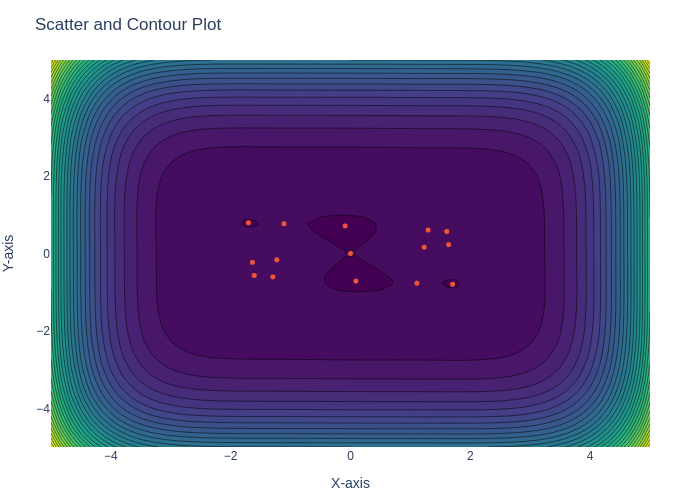

In [7]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 60  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]

#Scatter plot the critical points of the approximant
scatter_traces = [scatter(x=df.x, y=df.y, mode="markers", marker_size=5, name="Critical Points")]

# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=40, colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]

# Customize layout to handle legend groups
layout = Layout(
    title="Scatter and Contour Plot",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=800, # Increase the height to make room for the legend 
    width=1000
)

# Display the combined plot with legend
display(plot(all_traces, layout))



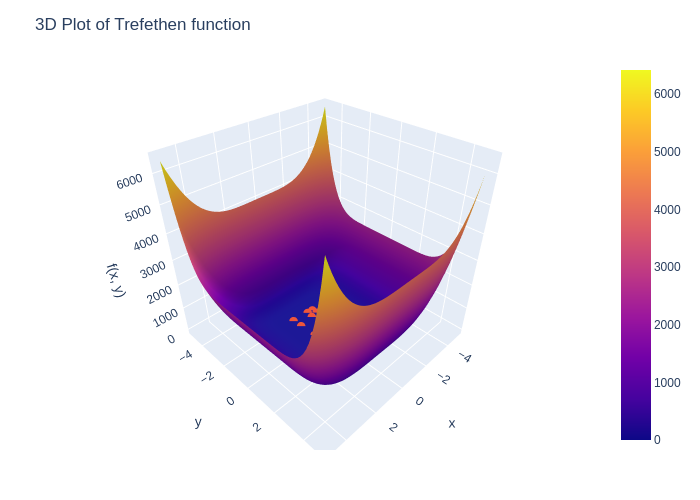

In [8]:
sf = surface(x=x, y=y, z=z)
# Had to switch the coordinates of the critical points to match the surface plot for some reason. 
crit_pts = scatter3d(x=df.y, y=df.x, z=df.z, mode="markers", marker_size=5, name="Critical Points")

# Layout for the plot
layout = Layout(title="3D Plot of Trefethen function",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"),
        height=800
)
# Display the plot layout,
plot([sf,  crit_pts], layout)

In [9]:
# using CSV 

# CSV.write("camel_3_d$d.csv", df)
# CSV.write("../data/camel_d$d.csv", df)